<h1>First prototype: encode-decode-predict the immediate nearest neighbor</h1>
In order to check if it's possible to learn a metric minimizer.
Based on https://medium.com/the-modern-scientist/graph-neural-networks-series-part-3-node-embedding-36613cc967d5
and https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/ and suggestions of Florian Racoussier.

<h2>1-NN data</h2>
Create a simple dataset for testing the prototype. Each node is connected to at most 15 neighbors in order to provide structure.

In [1]:
from math import sqrt
import torch
from torch_geometric.data import Data
from random import randint
from sys import float_info
from torch_geometric.nn import knn_graph

instances = {}
for k in range(0, 1000):
    nodes = {}
    for i in range(0, 50):
        lat_i = randint(0, 100)
        lon_i = randint(0, 100)
        node_i = (lat_i, lon_i)
        lat_j = randint(0, 100)
        lon_j = randint(0, 100)
        node_j = (lat_j, lon_j)
        nodes[i + 1] = node_i
        nodes[i + 51] = node_j

    dist = {}
    pairs = {}
    for i in range(1, 101):
        for j in range(1, 101):
            if i != j:
                dist[i,j] = sqrt( (nodes[i][0] - nodes[j][0])**2 + (nodes[i][1] - nodes[j][1])**2 )
            else:
                dist[i,j] = float_info.max
    for i in range(1, 101):
        for j in range(1, 101):
            if i not in pairs:
                pairs[i] = j
            if i != j:
                if dist[i,j] < dist[i,pairs[i]]:
                    pairs[i] = j

    nodes[0] = (0,0)
    for i in range(1,101):
        dist[0,i] = sqrt( (nodes[0][0] - nodes[i][0])**2 + (nodes[0][1] - nodes[i][1])**2 )
        dist[i,0] = dist[0,i]
    y = [[0 for _ in range(101)] for _ in range(101)]
    for i in range(101):
        if i > 0:
            y[i][pairs[i]] = 1
                
    instances[k] = {"nodes": nodes, "dist": dist, "y": y}
data_list = []
for instance_name in instances:
    y = torch.tensor(instances[instance_name]["y"], dtype=torch.float)
    x = torch.tensor([instances[instance_name]["nodes"][i] for i in range(0, 101)], dtype=torch.float)
    pos = []
    for i in range(101):
        pos.append(instances[instance_name]["nodes"][i])
    pos = torch.tensor(pos, dtype=torch.double)
    data_list.append(Data(x=x, y=y, edge_index = knn_graph(x, 15), pos=pos))

<h2>1-NN Batching and dividing data into train-test-validation</h2>

In [2]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

def add_edge_labels(graph):
    transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False)
    return transform(graph)

labeled_graphs = [add_edge_labels(graph) for graph in data_list]

train_size = [g[0] for g in labeled_graphs]
val_size = [g[1] for g in labeled_graphs]
test_size = [g[2] for g in labeled_graphs]

train_loader = DataLoader(train_size, batch_size=20, shuffle=True)
val_loader = DataLoader(val_size, batch_size=20, shuffle=False)
test_loader = DataLoader(test_size, batch_size=20, shuffle=False)

<h2>Encoder-Decoder architecture definition</h2>
Add text here

In [3]:
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

model = Net(data_list[0].num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

<h2>Encoder-Decoder train-test-validate routine</h2>
Add text here

In [4]:
from sklearn.metrics import roc_auc_score

def train(loader):
    model.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()
        z = model.encode(batch.x, batch.edge_index)

        # We perform a new round of negative sampling for every training epoch:
        neg_edge_index = negative_sampling(
            edge_index=batch.edge_index, num_nodes=batch.num_nodes,
            num_neg_samples=batch.edge_label_index.size(1), method='sparse')

        # Concat positive and negative edge indices.
        edge_label_index = torch.cat(
            [batch.edge_label_index, neg_edge_index],
            dim=-1,
        )
        # Label for positive edges: 1, for negative edges: 0.
        edge_label = torch.cat([
            batch.edge_label,
            batch.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        # Note: The model is trained in a supervised manner using the given
        # `edge_label_index` and `edge_label` targets.
        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def test(loader):
    model.eval()
    all_out = []
    all_labels = []

    for batch in loader:
        z = model.encode(batch.x, batch.edge_index)
        out = model.decode(z, batch.edge_label_index).view(-1).sigmoid()
        all_out.append(out.cpu().numpy())
        all_labels.append(batch.edge_label.cpu().numpy())

    all_out = np.concatenate(all_out)
    all_labels = np.concatenate(all_labels)
    return roc_auc_score(all_labels, all_out)

In [5]:
# Train/Test Loop
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train(train_loader)
    val_auc = test(val_loader)
    test_auc = test(test_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 122.2200, Val: 0.8519, Test: 0.8531
Epoch: 002, Loss: 1.4640, Val: 0.8638, Test: 0.8646
Epoch: 003, Loss: 0.7274, Val: 0.8689, Test: 0.8694
Epoch: 004, Loss: 0.5976, Val: 0.8711, Test: 0.8717
Epoch: 005, Loss: 0.5664, Val: 0.8718, Test: 0.8725
Epoch: 006, Loss: 0.5568, Val: 0.8731, Test: 0.8737
Epoch: 007, Loss: 0.5530, Val: 0.8743, Test: 0.8747
Epoch: 008, Loss: 0.5514, Val: 0.8757, Test: 0.8763
Epoch: 009, Loss: 0.5502, Val: 0.8769, Test: 0.8774
Epoch: 010, Loss: 0.5489, Val: 0.8782, Test: 0.8787
Epoch: 011, Loss: 0.5481, Val: 0.8803, Test: 0.8808
Epoch: 012, Loss: 0.5472, Val: 0.8815, Test: 0.8821
Epoch: 013, Loss: 0.5464, Val: 0.8841, Test: 0.8847
Epoch: 014, Loss: 0.5448, Val: 0.8862, Test: 0.8868
Epoch: 015, Loss: 0.5435, Val: 0.8886, Test: 0.8890
Epoch: 016, Loss: 0.5421, Val: 0.8917, Test: 0.8921
Epoch: 017, Loss: 0.5410, Val: 0.8945, Test: 0.8950
Epoch: 018, Loss: 0.5394, Val: 0.8979, Test: 0.8983
Epoch: 019, Loss: 0.5358, Val: 0.9014, Test: 0.9020
Epoch: 020

<h2>1-NN additional statistics</h2>
Add text here

In [6]:
graph_dict = {}
cnt = 0
for graph in data_list:
    z_raw = model.encode(graph.x, graph.edge_index)
    final_edge_index = model.decode_all(z_raw)
    fei = final_edge_index.tolist()
    edges_pred = {k:[] for k in range(101)}
    edges_pred_inv = {k:[] for k in range(101)}
    for i in range(len(fei[0])):
        edges_pred[fei[0][i]].append(fei[1][i])
        edges_pred_inv[fei[1][i]].append(fei[0][i])
    ts0 = graph.edge_index.tolist()
    edges = {k:[] for k in range(101)}
    edges_inv = {k:[] for k in range(101)}
    for i in range(len(ts0[0])):
        edges[ts0[0][i]].append(ts0[1][i])
        edges_inv[ts0[1][i]].append(ts0[0][i])
    originals = {}
    predictions = {}
    for i in range(101):
        originals[i] = set(edges[i] + edges_inv[i])
        predictions[i] = set(edges_pred[i] + edges_pred_inv[i])
    graph_dict[cnt] = {"real": originals, "preds": predictions}
    cnt += 1

confusion_dict = {}
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
for key in graph_dict:
    real = graph_dict[key]["real"]
    pred = graph_dict[key]["preds"]
    node_matrix = {}
    for i in range(101):
        tp = len(pred[i].intersection(real[i]))
        fp = len(pred[i] - real[i])
        real_neg = set([j for j in range(101)]) - {i} - real[i]
        pred_neg = set([j for j in range(101)]) - {i} - pred[i]
        tn = len(pred_neg.intersection(real_neg))
        fn = len(pred_neg - real_neg)
        total = tp + fp + tn + fn
        node_matrix[i] = {"tp": tp, "fp": fp, "tn": tn, "fn": fn, "total": total}
        true_positives.append(tp/total)
        false_positives.append(fp/total)
        true_negatives.append(tn/total)
        false_negatives.append(fn/total)
    confusion_dict[key] = node_matrix

In [7]:
from statistics import mean, stdev
print("true positives mean={0:.2f}, stdev={1:.2f}".format(mean(true_positives), stdev(true_positives)))
print("false positives mean={0:.2f}, stdev={1:.2f}".format(mean(false_positives), stdev(false_positives)))
print("true negatives mean={0:.2f}, stdev={1:.2f}".format(mean(true_negatives), stdev(true_negatives)))
print("false negatives mean={0:.2f}, stdev={1:.2f}".format(mean(false_negatives), stdev(false_negatives)))

true positives mean=0.17, stdev=0.03
false positives mean=0.28, stdev=0.10
true negatives mean=0.54, stdev=0.10
false negatives mean=0.00, stdev=0.00


There's some notion of closeness. It over-links, but rarely avoids a close node. Also, a middle stage as this is not always a requirement. We want to encode the data in embeddings that can be used for the next stage. The quality will be measured then over the ability to learn closeness.

<h2>1-NN data preparation for second stage</h2>
Add text here

In [8]:
from random import sample
data_raw_dict = {
    "positives": [],
    "negatives": []
}
cnt = 0
pos_cnt = 0
neg_cnt = 0
for graph in data_list:
    neg_cnt = 0
    ng_matrix = graph.y.tolist()
    encoding_matrix = model.encode(graph.x, graph.edge_index).tolist()
    for i in range(101):
        for j in sample(range(101), 30):
            if i == j:
                # if pos_cnt < 80000:
                #     data_raw_dict["positives"].append(encoding_matrix[i]+encoding_matrix[i])
                #     pos_cnt += 1
                continue
            else:
                if ng_matrix[i][j] > 0.5:
                    if pos_cnt < 80000:
                        data_raw_dict["positives"].append(encoding_matrix[i]+encoding_matrix[j]+[1])
                        pos_cnt += 1
                else:
                    if pos_cnt < 80000 and neg_cnt < 1010:
                        data_raw_dict["negatives"].append(encoding_matrix[i]+encoding_matrix[j]+[0])
                        neg_cnt += 1

In [9]:
pre_tensor = data_raw_dict["positives"][:5000] + data_raw_dict["negatives"][:5000]
main_tensor = torch.tensor(pre_tensor, dtype=torch.float32)

main_tensor = main_tensor[torch.randperm(main_tensor.size()[0])]
labels = main_tensor[:,-1:]
embeddings = main_tensor[:,:-1]

<h2>1-NN Wide or Deep network</h2>
Add text here

In [10]:
import torch.nn as nn

class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(128, 128)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 128)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(128, 128)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [11]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
 
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 20   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [12]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, train_size=0.7, shuffle=True)
 
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
 
# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Accuracy (wide): 0.93
Accuracy (wide): 0.94
Accuracy (wide): 0.92
Accuracy (wide): 0.94
Accuracy (wide): 0.93
Accuracy (deep): 0.95
Accuracy (deep): 0.94
Accuracy (deep): 0.95
Accuracy (deep): 0.95
Accuracy (deep): 0.95
Wide: 93.19% (+/- 0.53%)
Deep: 94.86% (+/- 0.42%)


In [13]:
# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Retrain a deep model
Final model accuracy: 95.13%


In [14]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[ 4.1717339e-01 -5.7865076e-02 -1.4151484e-02  1.5557876e-02
 -4.2768332e-01 -4.4370964e-01  3.3552490e-02  4.1792460e-02
 -4.4831714e-01 -7.0630580e-02  2.1677202e-01  2.2268556e-01
 -6.3116723e-01  8.4077612e-02  5.1827902e-01  3.1405866e-01
 -2.0323183e-01  8.0681220e-02  1.3163482e-01 -1.4057782e-01
 -1.0440167e-02  9.3202174e-02  1.8332930e-01  2.2968042e-01
  1.0498860e-01 -2.6336920e-01  5.9151962e-02  5.4599382e-02
 -5.2246571e-02 -2.9523142e-02  2.7236146e-01 -5.9649184e-02
 -2.9510462e-01 -2.3909754e-01 -2.0827483e-01 -4.0251181e-01
 -1.6330114e-01 -2.0440927e-01 -7.0687167e-02  2.9918218e-01
  9.8987930e-03  9.5853359e-02 -2.3753516e-01 -1.8214691e-01
 -4.3035455e-02 -1.5556519e-02 -1.2626988e-01  1.3818063e-01
 -2.8056109e-01  5.3613499e-02 -2.5029457e-01  3.6895238e-02
 -1.3619283e-01  5.3167921e-01 -3.1269984e-03 -3.6275232e-01
  2.5250453e-01  1.8157607e-01 -2.1313316e-01 -8.1577316e-02
  1.5478041e-02  2.6419458e-01  5.4498559e-01  2.4573167e-01
  4.3307829e-01 -5.64706

The one above is an example for visual validation

<h1>NgSets prototype, undirected</h1>
Once validated the simple prototype, let's continue to the actual problem

<h2>Load the data</h2>
Here an "export" folder with .txt instance files used on the CTWVRP project, and a .csv file with the neighborhoods.

In [2]:
import os

data_files_list = ["./export/"+f for f in os.listdir("./export") ]
instance_dict = {}
for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

ng_dict = {}
cnt = -1
with open("ng_outs.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            ng_dict[instance] = [[0 for i in range(101)]]
        ng_dict[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

In [4]:
# data_list = []
# for instance_name in ng_dict:
#     y = torch.tensor(ng_dict[instance_name], dtype=torch.double)
#     x = torch.tensor(instance_dict[instance_name], dtype=torch.double)
#     attr = [[i] for i in range(n_edges)]
#     loc_dict = {(i[0],j[0]): sqrt((i[1]-j[1])**2 + (i[2]-j[2])**2) for i in instance_dict[instance_name] for j in instance_dict[instance_name]}
#     cnt = -1
#     for i in range(101):
#         for j in range(101):
#             if i != j:
#                 cnt += 1
#                 attr[cnt].append(loc_dict[i,j])
#     attr = torch.tensor(attr, dtype=torch.double)
#     pos = []
#     for i in instance_dict[instance_name]:
#         pos.append([i[1], i[2]])
#     pos = torch.tensor(pos, dtype=torch.double)
#     data_list.append(Data(x=x, y=y, edge_index=edge_index, pos=pos, edge_attr=attr))

data_list = []
for instance_name in ng_dict:
    y = torch.tensor(ng_dict[instance_name], dtype=torch.float)
    x = torch.tensor(instance_dict[instance_name], dtype=torch.float)
    pos = []
    for i in instance_dict[instance_name]:
        pos.append([i[1], i[2]])
    pos = torch.tensor(pos, dtype=torch.double)
    data_list.append(Data(x=x, y=y, edge_index = knn_graph(pos, 15), pos=pos))

<h2>Prepare data as in prototype</h2>
Add text here

In [5]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

def add_edge_labels(graph):
    transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False)
    return transform(graph)

labeled_graphs = [add_edge_labels(graph) for graph in data_list]

train_size = [g[0] for g in labeled_graphs]
val_size = [g[1] for g in labeled_graphs]
test_size = [g[2] for g in labeled_graphs]

train_loader = DataLoader(train_size, batch_size=150, shuffle=True)
val_loader = DataLoader(val_size, batch_size=150, shuffle=False)
test_loader = DataLoader(test_size, batch_size=150, shuffle=False)

<h2>Encode-decode routine</h2>

In [6]:
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [7]:
model_ed = Net(data_list[0].num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model_ed.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [8]:
from sklearn.metrics import roc_auc_score

def train(loader):
    model_ed.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()
        z = model_ed.encode(batch.x, batch.edge_index)

        # We perform a new round of negative sampling for every training epoch:
        neg_edge_index = negative_sampling(
            edge_index=batch.edge_index, num_nodes=batch.num_nodes,
            num_neg_samples=batch.edge_label_index.size(1), method='sparse')

        # Concat positive and negative edge indices.
        edge_label_index = torch.cat(
            [batch.edge_label_index, neg_edge_index],
            dim=-1,
        )
        # Label for positive edges: 1, for negative edges: 0.
        edge_label = torch.cat([
            batch.edge_label,
            batch.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        # Note: The model is trained in a supervised manner using the given
        # `edge_label_index` and `edge_label` targets.
        out = model_ed.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def test(loader):
    model_ed.eval()
    all_out = []
    all_labels = []

    for batch in loader:
        z = model_ed.encode(batch.x, batch.edge_index)
        out = model_ed.decode(z, batch.edge_label_index).view(-1).sigmoid()
        all_out.append(out.cpu().numpy())
        all_labels.append(batch.edge_label.cpu().numpy())

    all_out = np.concatenate(all_out)
    all_labels = np.concatenate(all_labels)
    return roc_auc_score(all_labels, all_out)

In [9]:
# Train/Test Loop
best_val_auc = final_test_auc = 0
for epoch in range(1, 6):
    loss = train(train_loader)
    val_auc = test(val_loader)
    test_auc = test(test_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 3054.1865, Val: 0.5342, Test: 0.5341
Epoch: 002, Loss: 19.2132, Val: 0.6063, Test: 0.6062
Epoch: 003, Loss: 8.8700, Val: 0.6729, Test: 0.6726
Epoch: 004, Loss: 5.2983, Val: 0.7367, Test: 0.7363
Epoch: 005, Loss: 3.4569, Val: 0.7851, Test: 0.7852
Final Test: 0.7852


<h2>Check on values</h2>

In [28]:
graph_dict = {}
cnt = 0
for graph in data_list:
    z_raw = model_ed.encode(graph.x, graph.edge_index)
    final_edge_index = model_ed.decode_all(z_raw)
    fei = final_edge_index.tolist()
    edges_pred = {k:[] for k in range(101)}
    edges_pred_inv = {k:[] for k in range(101)}
    for i in range(len(fei[0])):
        edges_pred[fei[0][i]].append(fei[1][i])
        edges_pred_inv[fei[1][i]].append(fei[0][i])
    ts0 = graph.edge_index.tolist()
    edges = {k:[] for k in range(101)}
    edges_inv = {k:[] for k in range(101)}
    for i in range(len(ts0[0])):
        edges[ts0[0][i]].append(ts0[1][i])
        edges_inv[ts0[1][i]].append(ts0[0][i])
    originals = {}
    predictions = {}
    for i in range(101):
        originals[i] = set(edges[i] + edges_inv[i])
        predictions[i] = set(edges_pred[i] + edges_pred_inv[i])
    graph_dict[cnt] = {"real": originals, "preds": predictions}
    cnt += 1

confusion_dict = {}
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
for key in graph_dict:
    real = graph_dict[key]["real"]
    pred = graph_dict[key]["preds"]
    node_matrix = {}
    for i in range(101):
        tp = len(pred[i].intersection(real[i]))
        fp = len(pred[i] - real[i])
        real_neg = set([j for j in range(101)]) - {i} - real[i]
        pred_neg = set([j for j in range(101)]) - {i} - pred[i]
        tn = len(pred_neg.intersection(real_neg))
        fn = len(pred_neg - real_neg)
        total = tp + fp + tn + fn
        node_matrix[i] = {"tp": tp, "fp": fp, "tn": tn, "fn": fn, "total": total}
        true_positives.append(tp/total)
        false_positives.append(fp/total)
        true_negatives.append(tn/total)
        false_negatives.append(fn/total)
    confusion_dict[key] = node_matrix

In [29]:
from statistics import mean, stdev
print("true positives mean={0:.2f}, stdev={1:.2f}".format(mean(true_positives), stdev(true_positives)))
print("false positives mean={0:.2f}, stdev={1:.2f}".format(mean(false_positives), stdev(false_positives)))
print("true negatives mean={0:.2f}, stdev={1:.2f}".format(mean(true_negatives), stdev(true_negatives)))
print("false negatives mean={0:.2f}, stdev={1:.2f}".format(mean(false_negatives), stdev(false_negatives)))

true positives mean=0.25, stdev=0.04
false positives mean=0.59, stdev=0.21
true negatives mean=0.16, stdev=0.21
false negatives mean=0.00, stdev=0.01


<h2>NgLearning</h2>

In [172]:
from random import sample

data_raw_dict  = {
     "positives": [],
     "negatives": []
}

cnt = 0
pos_cnt = 0
neg_cnt = 0
indices = [i for i in range(len(data_list))]
for idx in sample(indices, 200):
    graph = data_list[idx]
    neg_cnt = 0
    ng_matrix = graph.y.tolist()
    x_matrix = graph.x.tolist()
    encoding_matrix = model_ed.encode(graph.x, graph.edge_index).tolist()
    for i in range(101):
        for j in range(101):
            if i == j:
                # if pos_cnt < 80000:
                #     data_raw_dict["positives"].append(encoding_matrix[i]+encoding_matrix[i])
                #     pos_cnt += 1
                continue
            else:
                if ng_matrix[i][j] > 0.5:
                        data_raw_dict["positives"].append(encoding_matrix[i]+x_matrix[i]+encoding_matrix[j]+x_matrix[j]+[1])
                        pos_cnt += 1
                else:
                    data_raw_dict["negatives"].append(encoding_matrix[i]+x_matrix[i]+encoding_matrix[j]+x_matrix[j]+[0])
                    neg_cnt += 1

In [178]:
pre_tensor = sample(data_raw_dict["positives"], 10000) + sample(data_raw_dict["negatives"], 10000)
main_tensor = torch.tensor(pre_tensor, dtype=torch.float32)

main_tensor = main_tensor[torch.randperm(main_tensor.size()[0])]
labels = main_tensor[:,-1:]
embeddings = main_tensor[:,:-1]

<h2>Learning stage</h2>

In [181]:
import torch.nn as nn

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 142)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(142, 70)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(70, 70)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(70, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [184]:
import torch.optim as optim
import tqdm
import copy

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 20   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [185]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, train_size=0.7, shuffle=True)
 
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model_ls = Deep()
    acc = model_train(model_ls, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
 
# evaluate the model
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Accuracy (deep): 0.80
Accuracy (deep): 0.79
Accuracy (deep): 0.80
Accuracy (deep): 0.80
Accuracy (deep): 0.80
Deep: 79.86% (+/- 0.41%)


In [186]:
model_ls = Deep()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Final model accuracy: 79.43%


In [53]:
model_ls.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model_ls(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[ 0.34824884 -0.36458543  0.34209353 -0.40368187  0.44998032 -0.6455222
 -0.24943261 -0.16076028  0.81623566  0.32858828  0.1401279   0.02790643
 -0.64043134 -0.74666744 -0.0035337  -0.56267107  0.25050822 -0.22999151
 -0.17261726  0.04425763 -0.3583087  -0.9353499  -0.15694048  0.81424946
  0.0312843  -0.3942736  -0.56929785 -0.21066405  0.14455457 -0.38482082
 -0.0708671  -0.03757123 -0.4867992  -0.9206139   0.33374938 -0.03163411
 -0.20573357 -1.358158   -0.11647518  0.32746667  0.5777776  -0.40665197
 -0.00517291  0.31417698  0.18779095 -0.8299682  -0.33597237  0.03479974
  0.11010712 -0.17035238  0.02037082  0.73113555 -0.25327745 -0.30412978
 -0.03329861 -0.6088855  -0.9155575  -0.09249165 -0.36688438  0.00162618
 -0.3377703   0.556208    0.49177033 -0.24819893  0.19426002 -0.54047716
  0.37577215 -0.4197988   0.5189862  -0.6187207  -0.19632323 -0.12735264
  0.816805    0.4287169   0.16433594 -0.03567228 -0.619009   -0.6863785
  0.10873306 -0.6471885   0.20190006 -0.21122718 -0.1

Test on instance 428

In [54]:
z_raw = model_ed.encode(data_list[428].x, data_list[428].edge_index)
preds = {}
for i in range(len(z_raw)):
    for j in range(len(z_raw)):
        if i != j:
            node_i = z_raw[i].tolist()
            node_j = z_raw[j].tolist()
            target = data_list[428].y[i][j]
            preds[i,j] = {"pred":model_ls(torch.tensor(node_i+node_j, dtype=torch.float)),"target":target}

In [63]:
preds[77,63]

{'pred': tensor([0.1292], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}

In [55]:
sums = {}
for i in range(101):
    sum_i = 0
    for j in range(101):
        if i != j:
            sum_i += preds[i,j]["pred"]
    sums[i] = sum_i
print(sums)

{0: tensor([21.5312], grad_fn=<AddBackward0>), 1: tensor([26.0008], grad_fn=<AddBackward0>), 2: tensor([40.3351], grad_fn=<AddBackward0>), 3: tensor([35.5938], grad_fn=<AddBackward0>), 4: tensor([38.9639], grad_fn=<AddBackward0>), 5: tensor([32.8199], grad_fn=<AddBackward0>), 6: tensor([26.7021], grad_fn=<AddBackward0>), 7: tensor([30.9510], grad_fn=<AddBackward0>), 8: tensor([21.5312], grad_fn=<AddBackward0>), 9: tensor([39.9153], grad_fn=<AddBackward0>), 10: tensor([35.4807], grad_fn=<AddBackward0>), 11: tensor([31.6647], grad_fn=<AddBackward0>), 12: tensor([27.4517], grad_fn=<AddBackward0>), 13: tensor([36.6048], grad_fn=<AddBackward0>), 14: tensor([38.6634], grad_fn=<AddBackward0>), 15: tensor([36.5882], grad_fn=<AddBackward0>), 16: tensor([22.8904], grad_fn=<AddBackward0>), 17: tensor([34.0399], grad_fn=<AddBackward0>), 18: tensor([37.7751], grad_fn=<AddBackward0>), 19: tensor([29.0070], grad_fn=<AddBackward0>), 20: tensor([35.7476], grad_fn=<AddBackward0>), 21: tensor([25.0341], 

Still space for improvement. I'd consider more data, undirected case for encoding and add tw into the structure of the graph

<h1>Hyperbolic tangent Ng-Set distinction</h1>
Add text here

In [1]:
import os

data_files_list = ["./export/"+f for f in os.listdir("./export") ]
instance_dict = {}
for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

ng_dict = {}
cnt = -1
with open("ng_outs.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            ng_dict[instance] = [[0 for i in range(101)]]
        ng_dict[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [240]:
from statistics import mean, stdev, median

statistic_dict = {}
for instance_name, ng_matrix in ng_dict.items():
    row_sum = []
    for i in range(1,101):
        row = ng_matrix[i][1:i] + ng_matrix[i][i+1:101]
        row_sum.append(sum(row))
    statistic_dict[instance_name] = {"avg": mean(row_sum), "std": stdev(row_sum), "median": median(row_sum)}

In [256]:
max_average = max(statistic_dict, key=lambda x: statistic_dict[x]["avg"])

In [258]:
statistic_dict[max_average]

{'avg': 5.49, 'std': 3.307460193153189, 'median': 5.0}

In [296]:
max_median = max(statistic_dict, key=lambda x: statistic_dict[x]["median"])

In [297]:
statistic_dict[max_median]

{'avg': 4.32, 'std': 2.4531159323965466, 'median': 5.0}

In [298]:
max_median

'J010093'

In [262]:
for line in ng_dict[max_average]:
    print(sum(line))

0
5
2
5
3
2
4
2
5
4
5
5
9
4
6
2
7
3
2
2
5
5
2
3
3
2
6
2
5
5
4
6
5
7
3
6
5
6
2
5
3
6
6
4
3
2
4
5
8
7
6
6
6
4
12
13
5
5
3
7
10
8
9
10
12
10
6
11
6
11
11
6
7
6
2
7
10
12
8
11
6
9
11
13
5
11
12
6
7
7
12
12
14
12
12
6
5
13
7
12
5


In [263]:
list(ng_dict.keys()).index(max_average)

9870

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

In [40]:
tw_distances = {i:{j:0 for j in range(101)} for i in range(101)}
print(tw_distances)

{0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0}, 1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 4

In [3]:
data_list = []
# def ranges_intersect(a, b, c, d):
#     return a <= d and c <= b
# def remove_edge(edge_index, u, v):
#     # Step 1: Identify all the edges that do not match [u, v]
#     mask = ~((edge_index[0] == u) & (edge_index[1] == v))
    
#     # Step 2: Filter the edge_index tensor using the mask
#     edge_index = edge_index[:, mask]
    
#     return edge_index


for instance_name in ng_dict:
    instance = instance_dict[instance_name]
    y = torch.tensor(ng_dict[instance_name], dtype=torch.float)
    x = torch.tensor(instance, dtype=torch.float)
    pos = []
    tw_sets_dict = {}
    for i in instance:
        pos.append([i[1], i[2]])
    # edges_to_prune = []
    # for i in range(101):
    #     for j in range(101):
    #         if i != j:
    #             if not ranges_intersect(instance[i][4], instance[i][5], instance[j][4], instance[j][5]):
    #                 i_ea = instance[i][4]
    #                 i_ld = instance[i][5]
    #                 j_ea = instance[j][4]
    #                 j_ld = instance[j][5]
    #                 dist = [abs(i_ea - j_ld), abs(j_ea - i_ld)]
    #                 tw_distances[i][j] = min(dist)
    #                 if min(dist) > 90:
    #                     edges_to_prune.append([i,j])
    # prune smth
    pos = torch.tensor(pos, dtype=torch.double)
    edge_index = knn_graph(pos, 15)
    # for e in edges_to_prune:
    #     u, v = e
    #     edge_index = remove_edge(edge_index, u, v)
    data_list.append(Data(x=x, y=y, edge_index=edge_index, pos=pos))

In [213]:
print(len(data_list))

19262


In [4]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from random import shuffle

def add_edge_labels(graph):
    transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False)
    return transform(graph)

labeled_graphs = [add_edge_labels(graph) for graph in data_list]
shuffle(labeled_graphs)

train_size = [g[0] for g in labeled_graphs]
val_size = [g[1] for g in labeled_graphs]
test_size = [g[2] for g in labeled_graphs]

train_loader = DataLoader(train_size, batch_size=150, shuffle=True)
val_loader = DataLoader(val_size, batch_size=150, shuffle=False)
test_loader = DataLoader(test_size, batch_size=150, shuffle=False)

In [196]:
print(labeled_graphs[0])
print(data_list[0])

(Data(x=[101, 7], edge_index=[2, 1276], y=[101, 101], pos=[101, 2], edge_label=[638], edge_label_index=[2, 638]), Data(x=[101, 7], edge_index=[2, 1276], y=[101, 101], pos=[101, 2], edge_label=[74], edge_label_index=[2, 74]), Data(x=[101, 7], edge_index=[2, 1350], y=[101, 101], pos=[101, 2], edge_label=[148], edge_label_index=[2, 148]))
Data(x=[101, 7], edge_index=[2, 1515], y=[101, 101], pos=[101, 2])


In [5]:
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        # x = self.conv2(x, edge_index).relu()
        # x = self.conv3(x, edge_index).relu()
        return self.conv4(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [36]:
model_ed = Net(data_list[0].num_features, 512, 64).to(device)
optimizer = torch.optim.Adam(params=model_ed.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve

def train(loader, epoch):
    model_ed.train()
    total_loss = 0

    if epoch == 8:
        for g in optimizer.param_groups:
            g['lr'] = 0.001

    for batch in loader:
        optimizer.zero_grad()
        z = model_ed.encode(batch.x, batch.edge_index)

        # We perform a new round of negative sampling for every training epoch:
        neg_edge_index = negative_sampling(
            edge_index=batch.edge_index, num_nodes=batch.num_nodes,
            num_neg_samples=batch.edge_label_index.size(1), method='sparse')

        # Concat positive and negative edge indices.
        edge_label_index = torch.cat(
            [batch.edge_label_index, neg_edge_index],
            dim=-1,
        )
        # Label for positive edges: 1, for negative edges: 0.
        edge_label = torch.cat([
            batch.edge_label,
            batch.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        # Note: The model is trained in a supervised manner using the given
        # `edge_label_index` and `edge_label` targets.
        out = model_ed.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def test(loader):
    model_ed.eval()
    all_out = []
    all_labels = []

    for batch in loader:
        z = model_ed.encode(batch.x, batch.edge_index)
        out = model_ed.decode(z, batch.edge_label_index).view(-1).sigmoid()
        all_out.append(out.cpu().numpy())
        all_labels.append(batch.edge_label.cpu().numpy())

    all_out = np.concatenate(all_out)
    all_labels = np.concatenate(all_labels)
    return roc_auc_score(all_labels, all_out), [all_labels], [all_out]

In [8]:
import matplotlib.pyplot as plt

In [37]:
# Train/Test Loop
best_val_auc = final_test_auc = 0
loss_collection = []
val_auc_collection = []
last_epoch = 30
for epoch in range(1, last_epoch + 1):
    if epoch > 5:
        rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
        rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
        if rate_of_change_in_loss * -1 > 0:
            if rate_of_change_in_val * -1 > 0:
                y_true = all_labels[0]
                y_pred = all_out[0]

                fpr, tpr, _ = roc_curve(y_true, y_pred)
                roc_auc = roc_auc_score(y_true, y_pred)

                plt.figure(1)
                plt.plot([0, 1], [0, 1], 'k-')
                plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                plt.xlabel('False positive rate')
                plt.ylabel('True positive rate')
                plt.title('ROC curve GCN network\n2 layers, Hidden width: 512, Output: 64')
                plt.legend(loc='best')
                plt.show()
                break
    loss = train(train_loader, epoch)
    val_auc, _, _ = test(val_loader)
    test_auc, all_labels, all_out = test(test_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')
    loss_collection.append(loss)
    val_auc_collection.append(val_auc)
    if epoch == last_epoch:
        y_true = all_labels[0]
        y_pred = all_out[0]

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k-')
        plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve GCN network\n2 layers, Hidden width: 512, Output: 64')
        plt.legend(loc='best')
        plt.show()


print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 2485.5013, Val: 0.5869, Test: 0.5855
Epoch: 002, Loss: 0.6727, Val: 0.6228, Test: 0.6210
Epoch: 003, Loss: 0.6645, Val: 0.6177, Test: 0.6161


KeyboardInterrupt: 

In [10]:
graph_dict = {}
cnt = 0
for graph in data_list:
    z_raw = model_ed.encode(graph.x, graph.edge_index)
    final_edge_index = model_ed.decode_all(z_raw)
    fei = final_edge_index.tolist()
    edges_pred = {k:[] for k in range(101)}
    edges_pred_inv = {k:[] for k in range(101)}
    for i in range(len(fei[0])):
        edges_pred[fei[0][i]].append(fei[1][i])
        edges_pred_inv[fei[1][i]].append(fei[0][i])
    ts0 = graph.edge_index.tolist()
    edges = {k:[] for k in range(101)}
    edges_inv = {k:[] for k in range(101)}
    for i in range(len(ts0[0])):
        edges[ts0[0][i]].append(ts0[1][i])
        edges_inv[ts0[1][i]].append(ts0[0][i])
    originals = {}
    predictions = {}
    for i in range(101):
        originals[i] = set(edges[i] + edges_inv[i])
        predictions[i] = set(edges_pred[i] + edges_pred_inv[i])
    graph_dict[cnt] = {"real": originals, "preds": predictions}
    cnt += 1

confusion_dict = {}
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
for key in graph_dict:
    real = graph_dict[key]["real"]
    pred = graph_dict[key]["preds"]
    node_matrix = {}
    for i in range(101):
        tp = len(pred[i].intersection(real[i]))
        fp = len(pred[i] - real[i])
        real_neg = set([j for j in range(101)]) - {i} - real[i]
        pred_neg = set([j for j in range(101)]) - {i} - pred[i]
        tn = len(pred_neg.intersection(real_neg))
        fn = len(pred_neg - real_neg)
        total = tp + fp + tn + fn
        node_matrix[i] = {"tp": tp, "fp": fp, "tn": tn, "fn": fn, "total": total}
        true_positives.append(tp/total)
        false_positives.append(fp/total)
        true_negatives.append(tn/total)
        false_negatives.append(fn/total)
    confusion_dict[key] = node_matrix

In [11]:
from statistics import mean, stdev
print("true positives mean={0:.2f}, stdev={1:.2f}".format(mean(true_positives), stdev(true_positives)))
print("false positives mean={0:.2f}, stdev={1:.2f}".format(mean(false_positives), stdev(false_positives)))
print("true negatives mean={0:.2f}, stdev={1:.2f}".format(mean(true_negatives), stdev(true_negatives)))
print("false negatives mean={0:.2f}, stdev={1:.2f}".format(mean(false_negatives), stdev(false_negatives)))

true positives mean=0.19, stdev=0.03
false positives mean=0.59, stdev=0.21
true negatives mean=0.22, stdev=0.21
false negatives mean=0.00, stdev=0.00


In [165]:
import sqlite3

conn = sqlite3.connect('full_pairing_embedding_1.db')
cur = conn.cursor()

columns = ', '.join([f'value{i} DECIMAL(10)' for i in range(1, 144)])

cur.execute(f'''
    CREATE TABLE IF NOT EXISTS positives (
        {columns}
    )
''')
conn.commit()
conn.close()
conn = sqlite3.connect('full_pairing_embedding_1.db')
cur = conn.cursor()
cur.execute(f'''
    CREATE TABLE IF NOT EXISTS negatives (
        {columns}
    )
''')

conn.commit()
conn.close()

In [18]:
from random import sample

indices = [i for i in range(len(data_list))]
conn = sqlite3.connect('full_pairing_embedding_1.db')
cur = conn.cursor()
for idx in sample(indices, 2000):
# for idx in indices:
    graph = data_list[idx]
    ng_matrix = graph.y.tolist()
    encoding_matrix = model_ed.encode(graph.x, graph.edge_index).tolist()
    
    for i in range(1,101):
        for j in range(1,101):
            if i == j:
                # if pos_cnt < 80000:
                #     data_raw_dict["positives"].append(encoding_matrix[i]+encoding_matrix[i])
                #     pos_cnt += 1
                continue
            else:
                
                if ng_matrix[i][j] > 0.5:
                    new_entry  = encoding_matrix[i]+graph.x[i].tolist()+encoding_matrix[j]+graph.x[j].tolist()+[1]
                    new_entry = ["%.5f" % e for e in new_entry]
                    new_entry = [float(e) for e in new_entry]
                    placeholders = ', '.join(['?'] * 143)
                    cur.execute(f'''
                        INSERT INTO positives ({', '.join([f'value{i}' for i in range(1, 144)])})
                        VALUES ({placeholders})
                    ''', new_entry)
                    conn.commit()
                else:
                    new_entry  = encoding_matrix[i]+graph.x[i].tolist()+encoding_matrix[j]+graph.x[j].tolist()+[0]
                    new_entry = ["%.5f" % e for e in new_entry]
                    new_entry = [float(e) for e in new_entry]
                    placeholders = ', '.join(['?'] * 143)
                    cur.execute(f'''
                        INSERT INTO negatives ({', '.join([f'value{i}' for i in range(1, 144)])})
                        VALUES ({placeholders})
                    ''', new_entry)
                    conn.commit()
conn.close()

Alternatively, is better a segmentation of tables

In [205]:
import sqlite3

conn = sqlite3.connect('ER_embeddings.db')
cur = conn.cursor()

columns = ', '.join([f'value{i} DECIMAL(10)' for i in range(1, 72)])

cur.execute(f'''
    CREATE TABLE IF NOT EXISTS embeddings (
        entry_id INT, 
        graph_id INT, 
        node_id INT, 
        {columns}
    )
''')
conn.commit()
conn.close()
conn = sqlite3.connect('ER_embeddings.db')
cur = conn.cursor()
cur.execute(f'''
    CREATE TABLE IF NOT EXISTS targets (
        target_id INT, 
        graph_id INT, 
        node_i_id INT, 
        node_j_id INT, 
        target INT
    )
''')

conn.commit()
conn.close()

In [209]:
conn = sqlite3.connect('ER_embeddings.db')
indices = [i for i in range(len(data_list))]
cur = conn.cursor()
embeddings_idx = 0
targets_idx = 0
for graph_idx in sample(indices, 3):
    graph = data_list[graph_idx]
    ng_matrix = graph.y.tolist()
    graph_x = graph.x
    encoding_matrix = model_ed.encode(graph_x, graph.edge_index).tolist()
    graph_x = graph_x.tolist()
    for i in range(1,101):
        encode_i = encoding_matrix[i]
        node_i = graph_x[i]
        new_entry = encode_i + node_i
        new_entry = ["%.5f" % e for e in new_entry]
        new_entry = [float(e) for e in new_entry]
        new_entry = [embeddings_idx, graph_idx, i] + new_entry
        placeholders = ', '.join(['?'] * 74)
        cur.execute(f'''
            INSERT INTO embeddings (entry_id, graph_id, node_id, {', '.join([f'value{i}' for i in range(1, 72)])})
            VALUES ({placeholders})
        ''', new_entry)
        conn.commit()
        embeddings_idx += 1
        for j in range(1,101):
            target = int(ng_matrix[i][j])
            new_entry = [targets_idx, graph_idx, i, j, target]
            placeholders = ', '.join(['?'] * 5)
            cur.execute(f'''
                INSERT INTO targets (target_id, graph_id, node_i_id, node_j_id, target)
                VALUES ({placeholders})
            ''', new_entry)
            conn.commit()
            targets_idx += 1
conn.close()

In [22]:
conn = sqlite3.connect('full_pairing_embedding_1.db')
cur = conn.cursor()

cur.execute('SELECT * FROM positives ORDER BY RANDOM() LIMIT 2')
rows = cur.fetchall()

for row in rows:
    values = list(row)  # Convert the string back to a list of floats
    print(values)

conn.close()

[0.66118, 0.94838, -0.876, -0.41615, 0.04691, -0.16675, 0.22066, -1.54137, 1.06522, -0.10525, -0.70218, 0.69687, 0.04271, -0.28538, 0.33736, 0.1252, -0.23725, -0.24863, -0.93389, 0.62139, 1.41741, 1.14515, 0.63426, 0.12067, -0.38322, 0.80235, 0.09743, -1.18841, -0.65156, 0.07186, -0.28567, 1.30586, 0.8459, -0.32406, -0.4773, -0.83307, -0.08354, 0.08339, 0.57718, -0.12751, 1.44274, 2.01152, -0.22892, 0.75242, -0.54804, -0.86146, -1.30952, -0.40795, -0.26426, 0.37206, -0.35543, -0.33895, -0.78025, 0.74631, -0.18311, -0.60011, -0.88556, -0.61174, 0.49392, 0.14463, 0.1734, -0.08591, -1.37122, 1.09354, 89, 38, 51, 5, 69, 129, 5, 0.5623, 0.83388, -0.58978, -0.3412, 0.04648, -0.18592, 0.09629, -1.17214, 0.82701, -0.15364, -0.55551, 0.47671, 0.08338, -0.18229, 0.22717, 0.22672, -0.13553, -0.25909, -0.73256, 0.3921, 1.21664, 0.98731, 0.51993, 0.03022, -0.3539, 0.58093, 0.00815, -0.88521, -0.53244, 0.04313, -0.19526, 1.03785, 0.62545, -0.39687, -0.45633, -0.64313, -0.02626, 0.10135, 0.42857, -0.

In [187]:
conn = sqlite3.connect('full_pairing_embedding_1.db')
cur = conn.cursor()

cur.execute('SELECT * FROM positives ORDER BY RANDOM() LIMIT 20000')
rows = cur.fetchall()

pos_list = []

for idx in range(len(rows)):
    values_pos = list(rows[idx])  # Convert the string back to a list of floats
    pos_list.append(values_pos)

conn.close()

conn = sqlite3.connect('full_pairing_embedding_1.db')
cur = conn.cursor()

cur.execute('SELECT * FROM negatives ORDER BY RANDOM() LIMIT 20000')
rows2 = cur.fetchall()

neg_list = []

for idx in range(len(rows2)):
    values_neg = list(rows2[idx])  # Convert the string back to a list of floats
    neg_list.append(values_neg)

conn.close()

In [30]:
print(pos_list[30])

[-0.57898, -0.63049, 0.03278, 0.33593, 0.30389, 0.11502, -0.28721, 0.6724, 0.2678, 0.03665, 0.1683, 0.3719, -0.28926, 0.16718, -0.27839, -0.23663, 0.36102, 0.32207, 0.11786, 0.24861, -0.32926, -0.49168, -0.07949, 0.39353, 0.50661, 0.17755, 0.91301, -0.10856, 0.13453, -0.16025, 0.42263, -0.38474, -0.30971, 0.46857, 0.49044, -0.00892, -0.1835, -0.12363, -0.18695, -0.01489, -0.54967, -0.94709, -0.09228, -0.28446, 0.21309, 0.05564, -0.28252, 0.22293, -0.06702, -0.00716, -0.21626, -0.37727, 0.35125, -0.15354, 0.47556, 0.5335, -0.04678, 0.13895, 0.06938, -0.10934, 0.25334, 0.05662, -0.22331, 0.19743, 27, 41, 55, 6, 75, 200, 5, -0.64889, -0.73155, 0.04294, 0.38883, 0.30609, 0.17854, -0.22642, 0.7292, 0.2846, 0.0066, 0.09824, 0.46888, -0.26736, 0.24834, -0.28329, -0.21928, 0.42779, 0.38769, 0.13209, 0.35454, -0.41046, -0.57952, -0.0683, 0.42151, 0.6017, 0.19189, 1.03908, -0.07304, 0.11303, -0.15415, 0.40265, -0.42645, -0.2824, 0.55708, 0.57193, -0.05859, -0.21775, -0.09719, -0.20391, 0.05325, 

Another alternative is following that architecture directly in RAM

In [30]:
from random import sample

indices = [i for i in range(len(data_list))]

encodings_dict = {}
targets_dict = {"positives": [], "negatives": []}

from ipywidgets import IntProgress
from IPython.display import display
import time

max_count = 19000
cnt = 0

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar
for graph_idx in sample(indices, max_count):
    graph = data_list[graph_idx]
    ng_matrix = graph.y.tolist()
    graph_x = graph.x
    encoding_matrix = model_ed.encode(graph_x, graph.edge_index).tolist()
    graph_x = graph_x.tolist()
    for i in range(1,101):
        encode_i = encoding_matrix[i]
        node_i = graph_x[i]
        new_entry = encode_i + node_i
        new_entry = ["%.5f" % e for e in new_entry]
        new_entry = [float(e) for e in new_entry]
        encodings_dict[graph_idx, i] = new_entry
        for j in range(1,101):
            if i != j:
                target = int(ng_matrix[i][j])
                if target == 1:
                    targets_dict["positives"].append((graph_idx, i, j))
                else:
                    targets_dict["negatives"].append((graph_idx, i, j))
    f.value += 1
    cnt += 1


IntProgress(value=0, max=19000)

In [227]:
print(len(targets_dict["positives"]))

2457689


In [31]:
pos_candidates = sample(targets_dict["positives"], 200000)
neg_candidates = sample(targets_dict["negatives"], 200000)
pos_list = [encodings_dict[k[0], k[1]] + encodings_dict[k[0], k[2]] + [1] for k in pos_candidates]
neg_list = [encodings_dict[k[0], k[1]] + encodings_dict[k[0], k[2]] + [0] for k in neg_candidates]

In [229]:
pos_list[-1]

[0.4184,
 -0.14373,
 0.06703,
 -0.44273,
 -0.47975,
 0.80694,
 0.37194,
 -0.27625,
 -0.04178,
 -1.25133,
 -0.21375,
 0.44965,
 -0.00732,
 -0.56687,
 0.36277,
 0.2402,
 0.0597,
 -0.90626,
 -0.03987,
 0.12249,
 0.06044,
 -0.53177,
 0.63241,
 1.00007,
 1.13488,
 0.34054,
 -0.5171,
 0.16306,
 0.57901,
 -1.26873,
 0.53609,
 0.88927,
 -1.07014,
 0.33441,
 0.13584,
 0.06793,
 0.066,
 1.42043,
 -0.13282,
 -0.67707,
 -0.2292,
 -0.78642,
 -1.09499,
 -0.87302,
 -0.38874,
 -0.06499,
 -0.17514,
 0.137,
 0.16315,
 -0.2762,
 0.17752,
 0.11826,
 -0.59196,
 0.84782,
 -0.17292,
 0.46212,
 -0.01011,
 -0.3778,
 -0.08987,
 -0.58573,
 -0.25137,
 0.50901,
 -0.70423,
 0.17527,
 80.0,
 30.0,
 56.0,
 6.0,
 159.0,
 499.0,
 5.0,
 0.42659,
 -0.23607,
 0.06116,
 -0.40866,
 -0.41269,
 0.80919,
 0.34471,
 -0.37751,
 0.00146,
 -1.19498,
 -0.19214,
 0.35083,
 -0.08892,
 -0.61121,
 0.34402,
 0.25551,
 -0.02442,
 -0.82551,
 -0.17668,
 0.10556,
 0.07599,
 -0.5217,
 0.60992,
 0.88821,
 1.12171,
 0.34667,
 -0.57406,
 0.1420

In [32]:
pre_tensor = pos_list + neg_list
main_tensor = torch.tensor(pre_tensor, dtype=torch.float32)

main_tensor = main_tensor[torch.randperm(main_tensor.size()[0])]
labels = main_tensor[:,-1:]
embeddings = main_tensor[:,:-1]

In [30]:
labels2 = labels.clone()
labels2[labels2==0] = -1

tensor([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.]])

In [34]:
import torch.nn as nn

In [13]:
import torch.nn as nn

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 142) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(142, 71)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(71, 71)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(71, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [15]:
import torch.optim as optim
import tqdm
import copy

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 142-71, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 142-71, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [38]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.optim as optim
import tqdm
import copy

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, train_size=0.7, shuffle=True)

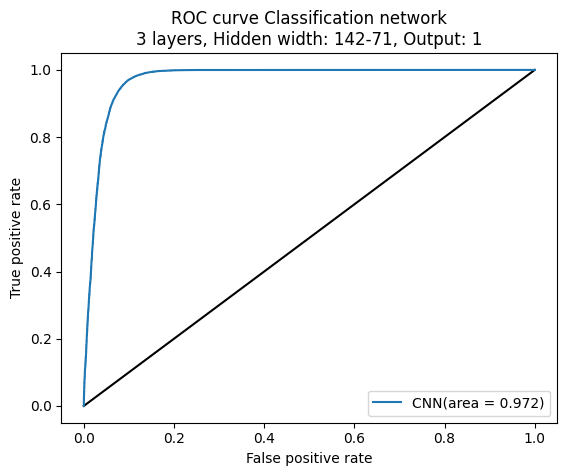

Accuracy (deep): 0.94


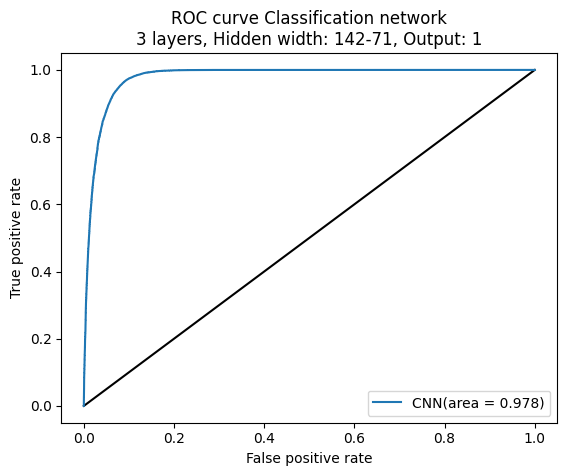

Accuracy (deep): 0.94


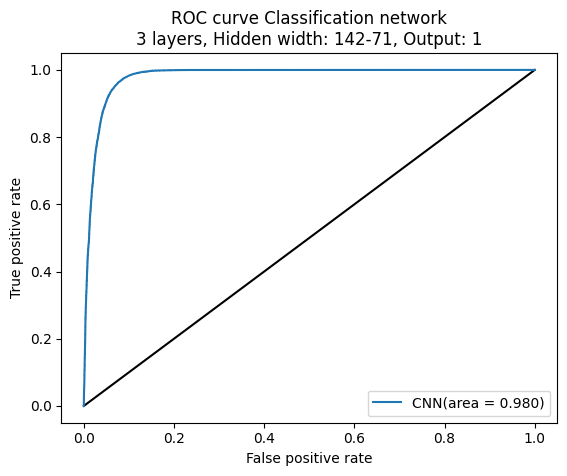

Accuracy (deep): 0.94


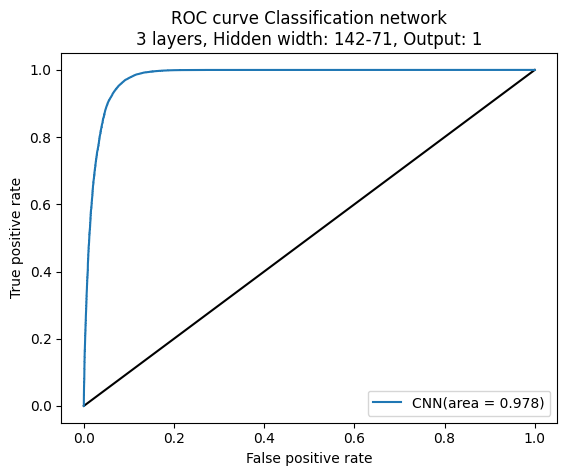

Accuracy (deep): 0.94


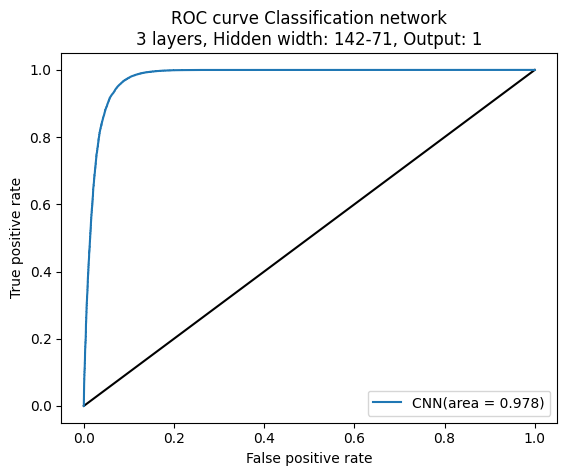

Accuracy (deep): 0.94
Deep: 93.98% (+/- 0.20%)


In [16]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, train_size=0.7, shuffle=True)
 
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model_ls = Deep()
    acc = model_train(model_ls, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
 
# evaluate the model
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

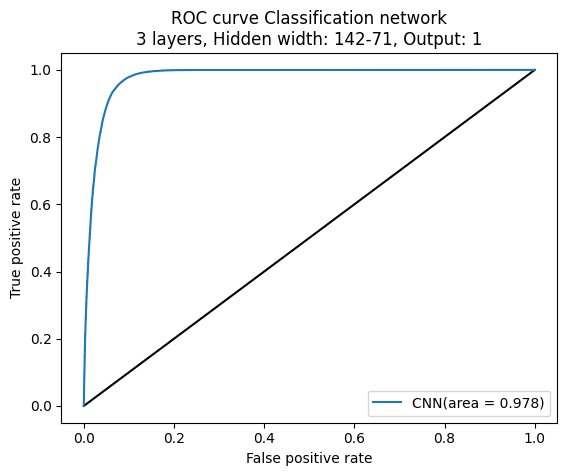

Final model accuracy: 94.17%


In [17]:
model_ls = Deep()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

In [18]:
import torch.nn as nn

class Deep2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 284) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(284, 284)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(284, 71)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(71, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [19]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 284, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 284, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

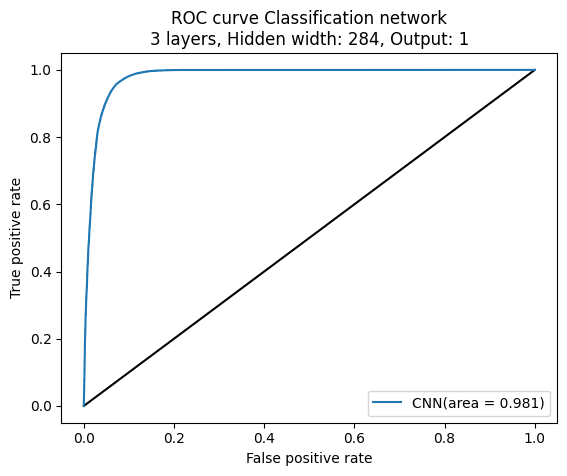

Accuracy (deep): 0.94


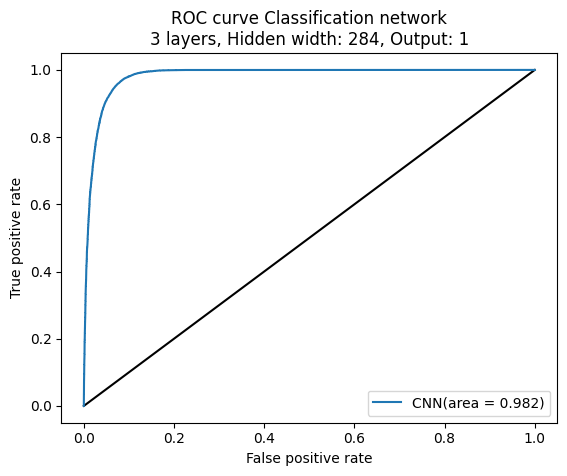

Accuracy (deep): 0.95


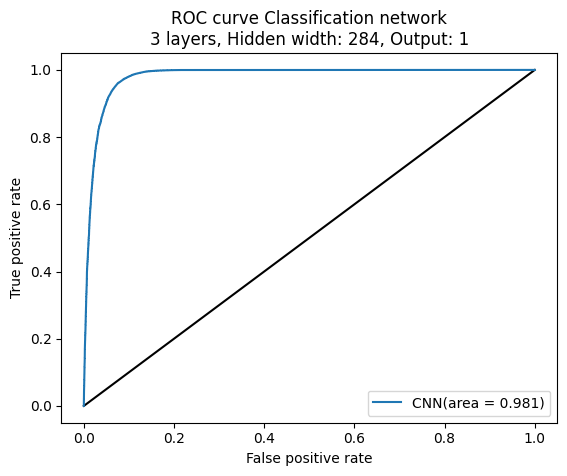

Accuracy (deep): 0.94


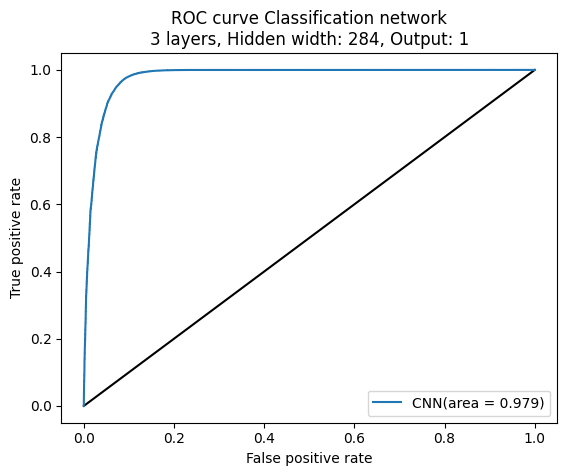

Accuracy (deep): 0.94


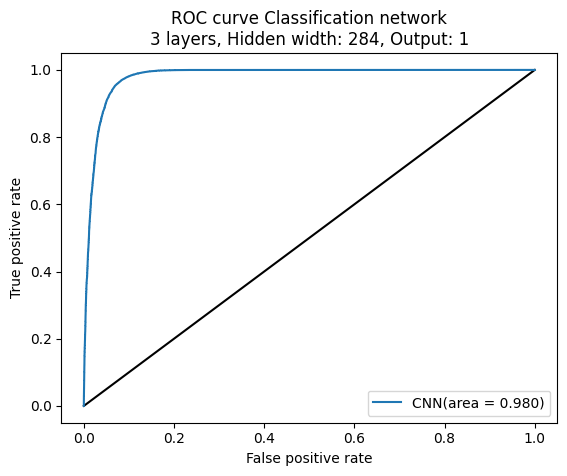

Accuracy (deep): 0.94
Deep: 94.40% (+/- 0.13%)


In [20]:
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, train_size=0.7, shuffle=True)
 
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model_ls = Deep2()
    acc = model_train(model_ls, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
 
# evaluate the model
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

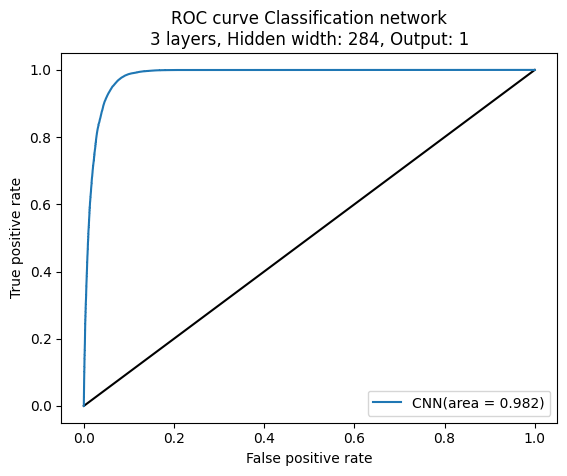

Final model accuracy: 94.80%


In [21]:
model_ls = Deep2()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

In [22]:
class Deep3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 426) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(426, 426)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(426, 71)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(71, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 426-71, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 426-71, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

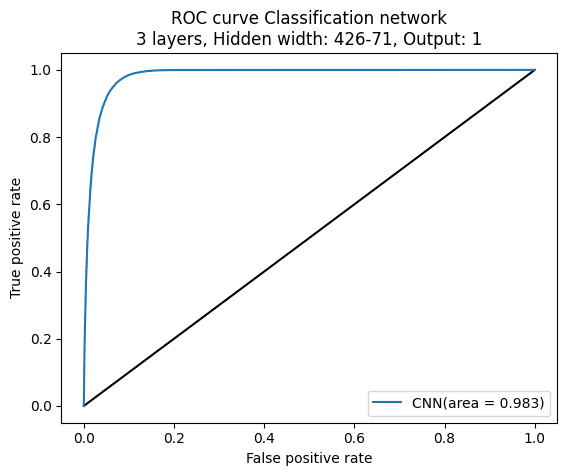

Final model accuracy: 94.54%


In [23]:
model_ls = Deep3()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

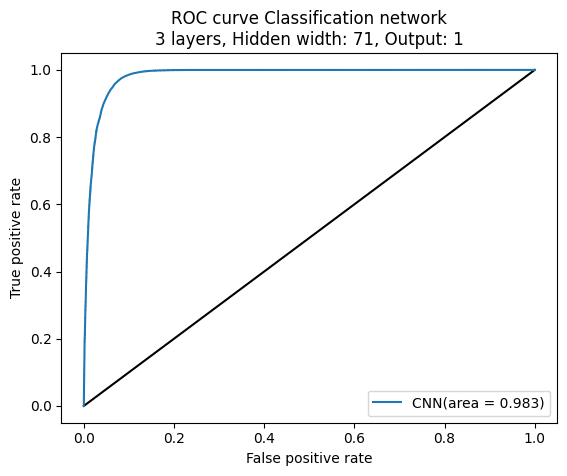

Final model accuracy: 94.59%


In [39]:
class Deep4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 71) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(71, 71)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(71, 71)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(71, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 71, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 71, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

model_ls = Deep4()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

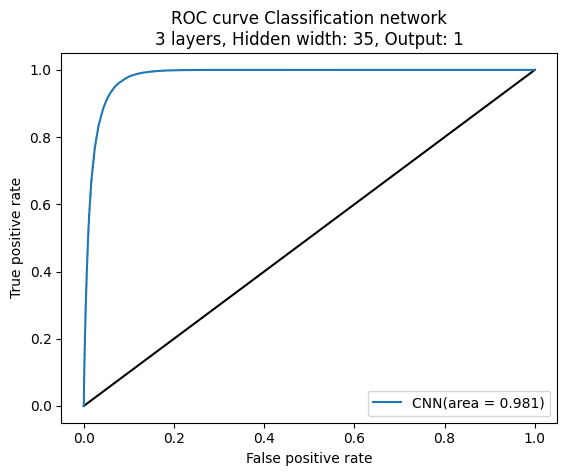

Final model accuracy: 94.22%


In [40]:
class Deep5(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 35) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(35, 35)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(35, 35)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(35, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 35, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 35, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

model_ls = Deep5()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

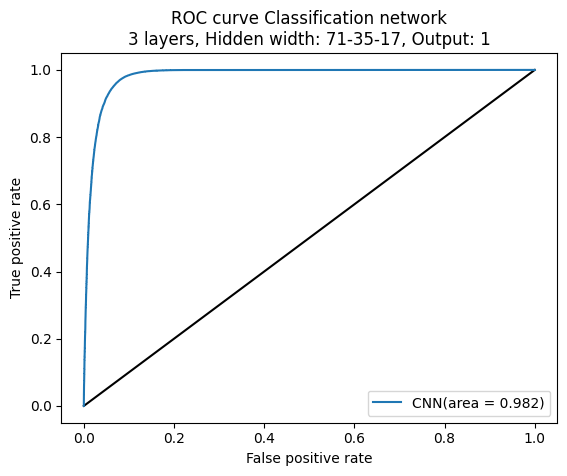

Final model accuracy: 94.50%


In [41]:
class Deep6(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 71) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(71, 35)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(35, 17)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(17, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 71-35-17, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 71-35-17, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

model_ls = Deep6()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

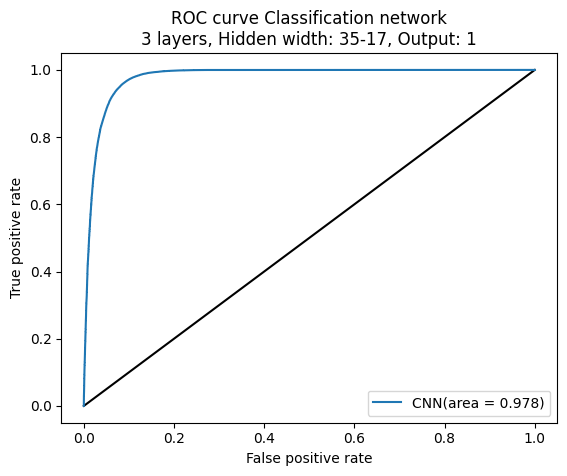

Final model accuracy: 93.83%


In [42]:
class Deep7(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 35) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(35, 17)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(17, 17)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(17, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 35-17, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 35-17, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

model_ls = Deep7()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

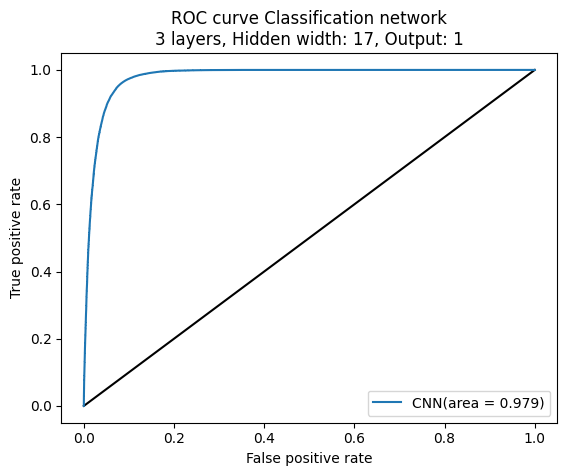

Final model accuracy: 93.87%


In [43]:
class Deep8(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 17) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(17, 17)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(17, 17)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(17, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 17, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 17, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

model_ls = Deep8()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

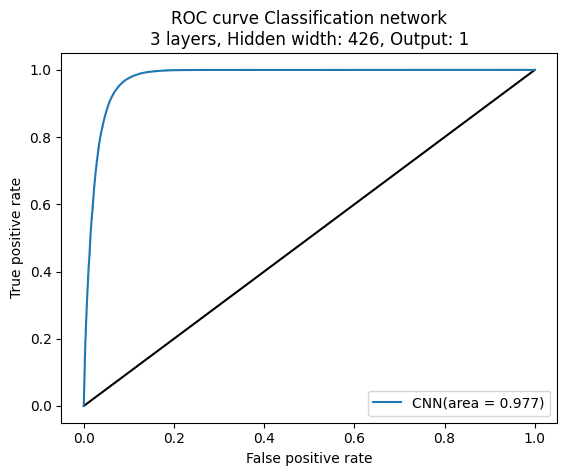

Final model accuracy: 93.89%


In [44]:
class Deep9(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(142, 426) #142
        self.act1 = nn.ReLU()
        # self.layer1_1 = nn.Linear(284, 142)
        # self.act1_1 = nn.ReLU()
        self.layer2 = nn.Linear(426, 426)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(426, 426)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(426, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        # x = self.act1_1(self.layer1_1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
 
    n_epochs = 60   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    loss_collection = []
    val_auc_collection = []
 
    for epoch in range(1,n_epochs+1):
        if epoch > 5:
            rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
            rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
            rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
            if rate_of_change_in_loss * -1 > 0:
                if rate_of_change_in_val * -1 > 0:
                    y_true = y_val
                    y_pred = y_pred

                    fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
                    roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

                    plt.figure(1)
                    plt.plot([0, 1], [0, 1], 'k-')
                    plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                    plt.xlabel('False positive rate')
                    plt.ylabel('True positive rate')
                    plt.title('ROC curve Classification network\n3 layers, Hidden width: 426, Output: 1')
                    plt.legend(loc='best')
                    plt.show()
                    break
        if epoch == 30:
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        loss_collection.append(loss)
        val_auc_collection.append(roc_auc_score(y_val, y_pred.detach().numpy()))
        if epoch == n_epochs:
            y_true = y_val
            y_pred = y_pred

            fpr, tpr, _ = roc_curve(y_true, y_pred.detach().numpy())
            roc_auc = roc_auc_score(y_true, y_pred.detach().numpy())

            plt.figure(1)
            plt.plot([0, 1], [0, 1], 'k-')
            plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve Classification network\n3 layers, Hidden width: 426, Output: 1')
            plt.legend(loc='best')
            plt.show()
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

model_ls = Deep9()
acc = model_train(model_ls, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

In [235]:
model_ls.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model_ls(X_test[5+i:i+6])
        list_row = X_test[i].tolist()
        length = len(list_row)
        ji_input = list_row[length//2:length] + list_row[:length//2]
        ji_input = torch.tensor(ji_input, dtype=torch.float)
        y_pred2 = model_ls(ji_input)
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()} and inverted {y_pred2.numpy()})")

[-3.10190e-01  5.43470e-01 -1.82600e-01 -2.74680e-01  2.91740e-01
 -9.97800e-02  4.17140e-01  8.66900e-02  5.69400e-02  6.43070e-01
  1.64420e-01 -2.55720e-01  3.10080e-01 -4.33800e-02  8.68300e-02
 -2.23030e-01  4.61050e-01  3.70760e-01  2.41250e-01 -7.05600e-02
 -3.24360e-01  3.37420e-01 -7.69910e-01 -6.22090e-01 -4.45230e-01
 -5.66360e-01  6.64520e-01  1.43640e-01 -6.93040e-01  6.89510e-01
 -8.53200e-02 -8.74920e-01  3.22580e-01 -6.71390e-01 -2.02150e-01
  3.60720e-01 -1.10080e-01 -4.84550e-01 -2.75330e-01  1.07700e-02
  1.88900e-02  4.54570e-01  1.20478e+00  4.09440e-01  3.68680e-01
  1.85700e-01  1.10010e-01  2.87500e-01  1.54750e-01 -5.00210e-01
 -3.95490e-01  1.69870e-01  1.75220e-01 -3.72710e-01  3.72370e-01
 -2.15690e-01 -1.03600e-02  9.26660e-01 -4.96740e-01  4.87910e-01
  4.44640e-01 -8.10500e-01 -5.47900e-02  7.02900e-02  6.00000e+00
  4.90000e+01  4.60000e+01  5.00000e+00  5.28000e+02  5.88000e+02
  5.00000e+00 -3.65200e-01  2.25570e-01 -2.40290e-01 -2.01410e-01
  5.56300e

In [236]:
z_raw = model_ed.encode(data_list[428].x, data_list[428].edge_index)
preds = {}
for i in range(len(z_raw)):
    for j in range(len(z_raw)):
        if i != j:
            node_i = z_raw[i].tolist() + data_list[428].x[i].tolist()
            node_j = z_raw[j].tolist() + data_list[428].x[j].tolist()
            target = data_list[428].y[i][j]
            preds[i,j] = {"pred":model_ls(torch.tensor(node_i+node_j, dtype=torch.float)),"target":target}

In [237]:
for i in range(101):
    if i != 77:
        print(i, preds[77,i])

0 {'pred': tensor([0.0039], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
1 {'pred': tensor([1.4214e-27], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
2 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
3 {'pred': tensor([3.4687e-16], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
4 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
5 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
6 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
7 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
8 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
9 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
10 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
11 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
12 {'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
13

In [27]:
preds[51,77]

{'pred': tensor([0.7944], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}

In [290]:
z_raw = model_ed.encode(data_list[9870].x, data_list[9870].edge_index)
preds = {}
for i in range(1,101):
    for j in range(1,101):
        if i != j:
            node_i = z_raw[i].tolist() + data_list[9870].x[i].tolist()
            node_j = z_raw[j].tolist() + data_list[9870].x[j].tolist()
            target = data_list[9870].y[i][j]
            prediction = model_ls(torch.tensor(node_i+node_j, dtype=torch.float))
            preds[i,j] = {"pred":prediction,"target":target}

In [303]:
instance_name = "JLA000011.txt"
folder = "./export/"
ng_outs_file = "ng_hard_instances.csv"
ng_outs_folder = "ng_sets/"

individual_instance = {}
with open(folder+instance_name, 'r') as text_file:
    cnt = 0
    instance = ""
    for line in text_file:
        if cnt < 9:
            if cnt == 0:
                instance = line.split()[0]
                individual_instance[instance] = []
            cnt += 1
            continue
        split_line = line.split()
        individual_instance[instance].append([int(i) for i in split_line])
    text_file.close()

ng_dict_aux = {}
cnt = -1
with open(ng_outs_folder+ng_outs_file, 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict_aux:
            ng_dict_aux[instance] = [[0 for i in range(101)]]
        ng_dict_aux[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [307]:
instance_name = "JLA000011"
instance = individual_instance[instance_name]
y = torch.tensor(ng_dict_aux[instance_name], dtype=torch.float)
x = torch.tensor(instance, dtype=torch.float)
pos = []
tw_sets_dict = {}
for i in instance:
    pos.append([i[1], i[2]])
pos = torch.tensor(pos, dtype=torch.double)
edge_index = knn_graph(pos, 15)
raw_instance = Data(x=x, y=y, edge_index=edge_index, pos=pos)

In [308]:
z_raw = model_ed.encode(raw_instance.x, raw_instance.edge_index)
preds = {}
for i in range(1,101):
    for j in range(1,101):
        if i != j:
            node_i = z_raw[i].tolist() + raw_instance.x[i].tolist()
            node_j = z_raw[j].tolist() + raw_instance.x[j].tolist()
            target = raw_instance.y[i][j]
            prediction = model_ls(torch.tensor(node_i+node_j, dtype=torch.float))
            preds[i,j] = {"pred":prediction,"target":target}

In [310]:
for j in range(1,101):
    if j != 7:
        print(preds[7,j])

{'pred': tensor([8.0259e-14], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([6.8951e-05], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([1.1437e-13], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([1.4733e-05], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([1.9763e-11], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.7987], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.0069], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.0015], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.8655], grad_fn=<SigmoidBackward0>), 'target': tensor(1.)}
{'pred': tensor([2.3728e-25], grad_fn=<SigmoidBackward0>), 'target':

In [314]:
torch.save(model_ed, 'encoder_decoder.pth')
torch.save(model_ls, 'classifier.pth')

In [315]:
ed = torch.load('encoder_decoder.pth')
cl = torch.load('classifier.pth')

In [316]:
z_raw = ed.encode(raw_instance.x, raw_instance.edge_index)
preds = {}
for i in range(1,101):
    for j in range(1,101):
        if i != j:
            node_i = z_raw[i].tolist() + raw_instance.x[i].tolist()
            node_j = z_raw[j].tolist() + raw_instance.x[j].tolist()
            target = raw_instance.y[i][j]
            prediction = cl(torch.tensor(node_i+node_j, dtype=torch.float))
            preds[i,j] = {"pred":prediction,"target":target}

In [317]:
for j in range(1,101):
    if j != 7:
        print(preds[7,j])

{'pred': tensor([8.0259e-14], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([6.8951e-05], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([1.1437e-13], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([1.4733e-05], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([1.9763e-11], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.7987], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.0069], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.0015], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.], grad_fn=<SigmoidBackward0>), 'target': tensor(0.)}
{'pred': tensor([0.8655], grad_fn=<SigmoidBackward0>), 'target': tensor(1.)}
{'pred': tensor([2.3728e-25], grad_fn=<SigmoidBackward0>), 'target':

In [321]:
z_raw = model_ed.encode(raw_instance.x, raw_instance.edge_index)
with open("text.txt", "w") as output_file:
    for i in range(1,101):
        line = ""
        for j in range(1,101):
            if i != j:
                if j > 1:
                    line += ","
                node_i = z_raw[i].tolist() + raw_instance.x[i].tolist()
                node_j = z_raw[j].tolist() + raw_instance.x[j].tolist()
                target = raw_instance.y[i][j]
                prediction = (1 if model_ls(torch.tensor(node_i+node_j, dtype=torch.float)) > 0.5 else 0)
                line += str(prediction)
            else:
                if j > 1:
                    line += ",1"
                else:
                    line+="1"
        line += "\n"
        output_file.write(line)